In [1]:
import datacube

In [2]:
dc = datacube.Datacube()

In [3]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import requests
import json
from bs4 import BeautifulSoup as bs

import numpy as np
from scipy import interpolate

from matplotlib import pyplot as plt


## get angles from metadata

In [36]:

def get_xml(ds):
    stac_json = ds.uris[0]
    bucket = stac_json.split('//')[1].split('/')[0]
    key = stac_json.split(bucket+'/')[1]
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    response = s3.get_object(Bucket = bucket, Key = key)
    jsonObject = json.loads(response['Body'].read())
    return jsonObject['assets']['metadata']['href']


def parse_xml(metadataurl):
    response = requests.get(metadataurl)
    parsed = bs(response.content)
    return parsed


def parse_values(angles_list):
    rows = [np.array(row.contents[0].split()).astype(float) for row in angles_list.find_all('values')]
    return np.vstack(rows)


def parse_and_fill(list_of_angles, mean_overlap=True):
    angles = parse_values(list_of_angles[0].values_list)
    
    for z in list_of_angles[1:]:
        det_angles = parse_values(z.values_list)
        empty = np.isnan(angles)
        angles[empty] = det_angles[empty]
        if mean_overlap:
            new_empty = np.isnan(det_angles)
            det_angles[new_empty] = angles[new_empty]
            angles = (angles+det_angles)/2

    return angles


In [115]:
# for each band, interpolate solar and viewing angles 

def s2_band_name_to_id(band_name):
    return {'B01':0, 'B02':1, 'B03':2, 'B04':3, 'B05':4, 'B06':5, 'B07':6, 'B08':7, 'B8A':8,
            'B09':9, 'B11':10, 'B12':11}[band_name]


def s2_band_name_to_res(band_name):
    return {'B01':20, 'B02':10, 'B03':10, 'B04':10, 'B05':20, 'B06':20, 'B07':20, 'B08':10, 'B8A':20,
            'B09':60, 'B11':20, 'B12':20}[band_name]


def get_image_size(parsed, res):
    size = [s for s in parsed.find_all('size') if int(s.attrs['resolution'])==res][0]
    return int(size.nrows.contents[0]), int(size.ncols.contents[0])


def fill_nan(row):
    valid = ~np.isnan(row)
    if valid.all(): return row
    output_x = np.arange(len(row))
    input_x = output_x[valid]
    f = interpolate.interp1d(input_x, row[valid], fill_value='extrapolate')
    return f(output_x)

def interpolate_table(table, row_step, col_step, res, nrows, ncols, **kw):
    ### problem with nan values
    
    y = np.arange(table.shape[0])*row_step/res
    x = np.arange(table.shape[1])*col_step/res
    rbs = interpolate.RectBivariateSpline(x, y, table, **kw)
    return rbs(np.arange(nrows), np.arange(ncols))


def get_angles(parsed, band_name, angletype='zenith', mean_overlap=True, **kw):
    
    band_id = s2_band_name_to_id(band_name)
    res = s2_band_name_to_res(band_name)
    nrows, ncols = get_image_size(parsed, res)
    
    angles = parsed.tile_angles.find_all(angletype)
    # separate solar and satellite
    solar_angles = [z for z in angles if 'sun' in z.parent.name][0]
    satellite_angles = [z for z in angles if 'viewing' in z.parent.name]

    solar_za = interpolate_table(parse_values(solar_angles),
                                 int(solar_angles.row_step.contents[0]), int(solar_angles.col_step.contents[0]),
                                 res, nrows, ncols, **kw)

    # satellite angles are provided for each detector
    table_raw = parse_and_fill(satellite_angles, mean_overlap=mean_overlap)
    table = np.vstack([fill_nan(row) for row in table_raw])
    satellite_za = interpolate_table(table,
                                 int(satellite_angles[0].row_step.contents[0]), int(satellite_angles[0].col_step.contents[0]),
                                 res, nrows, ncols)
    
    return solar_za, satellite_za, table_raw


In [43]:
%%time

dss = dc.find_datasets(product='s2_l2a', time='2020-01-01')
ds = dss[3]

xml = get_xml(ds)
parsed = parse_xml(xml)

CPU times: user 276 ms, sys: 19.9 ms, total: 295 ms
Wall time: 678 ms


In [168]:
%%time

band_name = 'B02'

solar_za, satellite_za, za = get_angles(parsed, band_name, 'zenith')
solar_az, satellite_az, az = get_angles(parsed, band_name, 'azimuth')

CPU times: user 7.56 s, sys: 660 ms, total: 8.22 s
Wall time: 8.22 s


In [169]:
%%time
solar_za_noavg, satellite_za_noavg, za_noavg = get_angles(parsed, band_name, 'zenith', mean_overlap=False)
solar_az_noavg, satellite_az_noavg, az_noavg = get_angles(parsed, band_name, 'azimuth', mean_overlap=False)

CPU times: user 7.56 s, sys: 672 ms, total: 8.23 s
Wall time: 8.23 s


nan


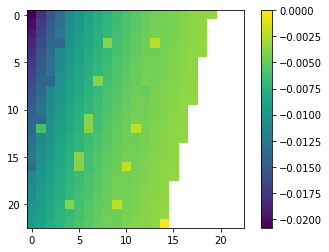

In [170]:
print((za-za_noavg).mean())
plt.imshow((za-za_noavg)/za);
plt.colorbar();

-0.047078123908394956


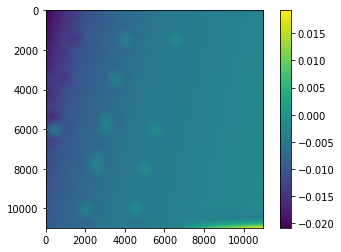

In [171]:
print((satellite_za-satellite_za_noavg).mean())
plt.imshow((satellite_za-satellite_za_noavg)/satellite_za);
plt.colorbar();

In [172]:
#check smoothness of za and satellite_za

def smooth_image(za_raw):
    za = np.vstack([fill_nan(row) for row in za_raw])
    f = interpolate.interp2d(np.arange(za.shape[0]), np.arange(za.shape[1]), za)
    a = f([0, za.shape[0]-1], np.arange(za.shape[1]))
    f = interpolate.interp2d([0, za.shape[0]-1], np.arange(za.shape[1]), a)
    return f(np.arange(za.shape[0]), np.arange(za.shape[1]))

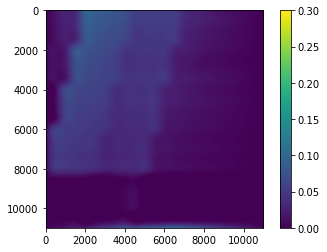

In [173]:
plt.imshow(smooth_image(satellite_za_noavg)-satellite_za_noavg, vmin=0, vmax=0.3);
plt.colorbar();

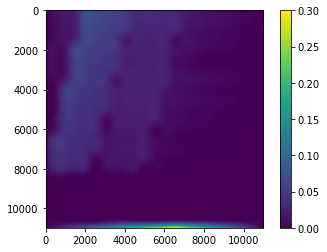

In [174]:
plt.imshow(smooth_image(satellite_za)-satellite_za, vmin=0, vmax=0.3);
plt.colorbar();

## apply to image

In [ ]:
# this appears to drop all nan columns
res = s2_band_name_to_res(band_name)
data = dc.load(product='s2_l2a', time='2020-01-01', datasets=[ds], output_crs=ds.crs, resolution=(-1*res, res), measurements=[band_name], dask={})

In [ ]:
from datacube.testutils.io import rio_slurp_xarray


data = rio_slurp_xarray(ds.uris[0].replace(ds.uris[0].split('/')[-1], ds.metadata_doc['measurements'][band_name]['path']))
data

In [ ]:
data.plot.imshow()